### **Libraries**

In [1]:
# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
import random
from collections import Counter

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Deep Learning
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# PGM
from pgmpy.models import BayesianNetwork, DynamicBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ParameterEstimator
from pgmpy.inference import VariableElimination

c:\Users\aleca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Datasets**

In this section, datasets are explain and loaded

####  **Share-races Dataset**

The `share-races.csv` file describes various sport events and races. Each row represents a specific race within an event. Key characteristics of this dataset include:

### Features:
- **Event ID**: Unique identifier for each event.
- **Race ID**: Unique identifier for each race.
- **Year**: Year in which the race took place.
- **Participants**: Number of participants who started the race.
- **Finish Rate**: Proportion of participants who finished the race (scaled by 100,000; e.g., 33333 means 33%).
- **First Finish Time**: Time taken by the first participant to complete the race.
- **Start Date**: Start date of the race.
- **Latitude and Longitude**: Geographical location of the race.
- **Total Distance**: Total distance of the race.
- **Dpos (Positive Difficulty)**: Measure of the added obstacles or difficulty in the race.
- **Altitude (Min/Mean/Max)**: Minimum, mean, and maximum altitudes of the race.

#### **Share-splits Dataset**

The `share-splits.csv` file provides detailed information about participant performance at various checkpoints during races. Each row represents a split (checkpoint) for a specific participant in a race.

### Features:
- **Participant ID**: Unique identifier for each participant.
- **Race ID**: Identifier linking to a race in the `share-races` dataset.
- **Split Time**: Time (in seconds) taken by the participant to reach the checkpoint since the start of the race.
- **Distance**: Distance (in meters) from the start of the race to the checkpoint.
- **Dpos (Checkpoint Difficulty)**: Positive difficulty measure of the checkpoint.

In [2]:
races = pd.read_csv("data/share-races.csv", sep=';')
splits = pd.read_csv("data/share-splits.csv", sep=';')

In [3]:
print(races.shape)
print(races.head(10))
print(splits.shape)
print(splits.head(10))

(4620, 13)
   event  year    race  nb_started  prop_dropped time_first  \
0  E0000  2019  R00000           3         33333   18:57:41   
1  E0001  2019  R00001         322          8695   06:27:47   
2  E0002  2024  R00002         131           763   12:11:00   
3  E0003  2022  R00003        1541         31278   05:10:15   
4  E0004  2022  R00004          17         17647   14:53:11   
5  E0005  2021  R00005          26         30769   16:45:40   
6  E0006  2017  R00006         154             0   01:29:55   
7  E0007  2022  R00007         119         43697   22:53:57   
8  E0008  2022  R00008         406          9359   05:32:33   
9  E0009  2024  R00009          12          8333   05:42:16   

            date_start  latitude  total_dist  total_dpos  min_alt  mean_alt  \
0  2019-06-15 05:00:00      -999     -999.00        -999     -999      -999   
1  2019-09-14 06:02:22        46       59.33        3725      815      1381   
2  2024-06-23 09:32:00        38      111.25        2862  

#### **Handling missing values**

The `share-races` dataset contained missing values (`-999`) in several columns: `latitude`, `min_alt`, `mean_alt`, `max_alt`, `total_dist`, and `total_dpos`. These values were handled as follows:

1. **Replace `-999` with `NaN`**:
   - All occurrences of `-999` were replaced with `NaN` to simplify handling missing data using Python's built-in tools.

2. **Imputation for Geographical and Altitude Columns**:
   - For columns `latitude`, `min_alt`, `mean_alt`, and `max_alt`, missing values were replaced with the **median** of their respective columns. The median is robust to outliers and provides a reasonable estimate for missing values.

3. **Imputation for `total_dist` and `total_dpos`**:
   - For these columns, missing values were filled with the **median of their group**, where groups were defined by the `event` column. This ensures that imputation is context-sensitive, preserving relationships between races within the same event.

In [4]:
races_numeric = races[['nb_started', 'prop_dropped', 'latitude', 'total_dist', 
                       'total_dpos', 'min_alt', 'mean_alt', 'max_alt']]

splits_numeric = splits[['finish', 'dist', 'dpos', 'alt', 'time']]

pd.set_option('future.no_silent_downcasting', True)
races.replace(-999, pd.NA, inplace=True)

for col in ['latitude', 'min_alt', 'mean_alt', 'max_alt']:
    races[col] = races[col].fillna(races[col].median())

races['total_dist'] = races.groupby('event')['total_dist'].transform(
    lambda x: x if x.isnull().all() else x.fillna(x.median())
)
races['total_dpos'] = races.groupby('event')['total_dpos'].transform(
    lambda x: x if x.isnull().all() else x.fillna(x.median())
)

# Replace any residual missing values with the column median
races['total_dist'] = races['total_dist'].fillna(races['total_dist'].median())
races['total_dpos'] = races['total_dpos'].fillna(races['total_dpos'].median())

print(races.shape)
print(races.head(10))

(4620, 13)
   event  year    race  nb_started  prop_dropped time_first  \
0  E0000  2019  R00000           3         33333   18:57:41   
1  E0001  2019  R00001         322          8695   06:27:47   
2  E0002  2024  R00002         131           763   12:11:00   
3  E0003  2022  R00003        1541         31278   05:10:15   
4  E0004  2022  R00004          17         17647   14:53:11   
5  E0005  2021  R00005          26         30769   16:45:40   
6  E0006  2017  R00006         154             0   01:29:55   
7  E0007  2022  R00007         119         43697   22:53:57   
8  E0008  2022  R00008         406          9359   05:32:33   
9  E0009  2024  R00009          12          8333   05:42:16   

            date_start latitude total_dist total_dpos min_alt mean_alt max_alt  
0  2019-06-15 05:00:00     45.0      42.53     1620.0   410.0    780.5  1124.0  
1  2019-09-14 06:02:22       46      59.33       3725     815     1381    1935  
2  2024-06-23 09:32:00       38     111.25       286

### **Data Analysis**

#### **Share-races Dataset:**

1. **Distribution of Race-Level Properties**:
   - Histograms show the distribution of `total_dist` (race distance) and `total_dpos` (positive difficulty).
   - These properties reveal the variability and difficulty levels across races.
2. **Correlation Analysis**:
   - A correlation matrix highlights the relationship between `total_dist` and `total_dpos`, showing how distance and difficulty are interrelated.
3. **Dropping Rate Analysis**:
   - The average proportion of dropped participants (`prop_dropped`) is computed per event, identifying events with higher participant dropout rates.

#### **Share-splits Dataset:**

1. **Participants per Race**:
   - Bar plots illustrate the number of participants per race, highlighting the variability in participation.
2. **Split Times Distribution**:
   - A histogram of split times (`time`) shows how participant performance evolves through checkpoints.

### **Combined Dataset Analysis**

The datasets were merged on the `race` column to analyze the relationship between race-level properties and participant performance.

1. **Average Dropping Rate by Event**: Average dropping rates were calculated across events in the combined dataset to identify patterns.
2. **Split Times vs. Total Distance**: A scatter plot of split times (`time`) against total race distance (`total_dist`) explores how race distance influences participant performance.

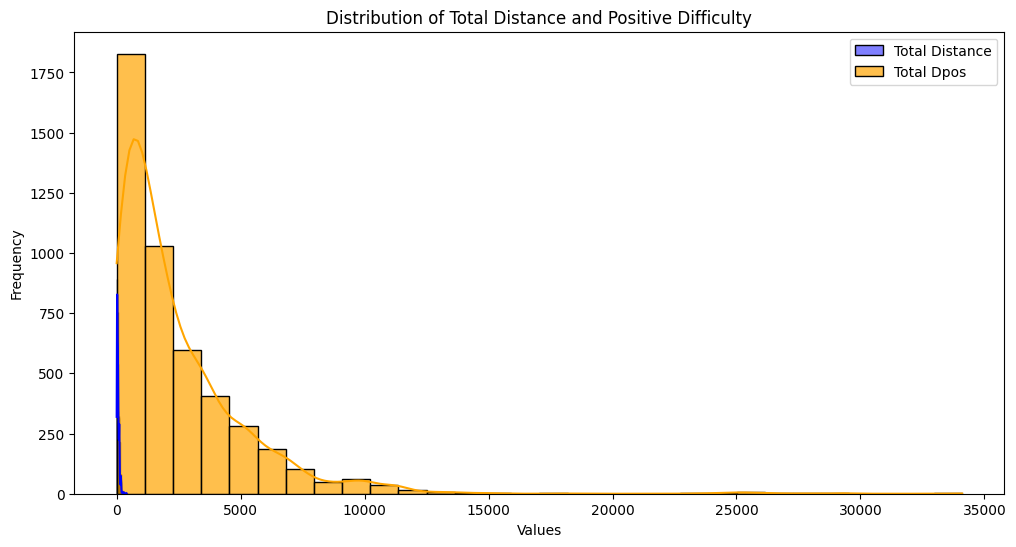

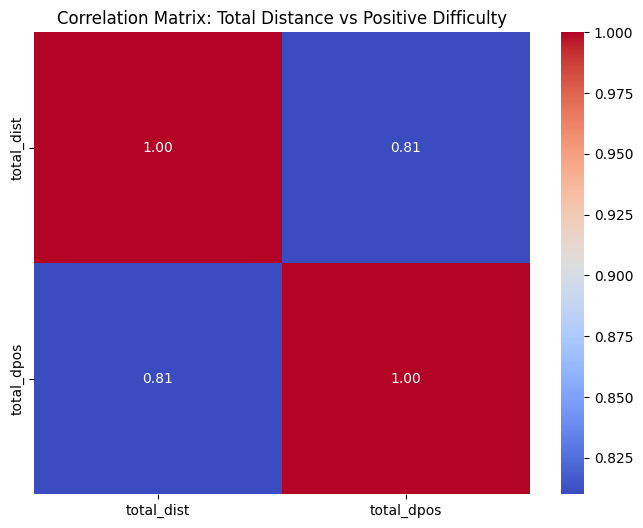

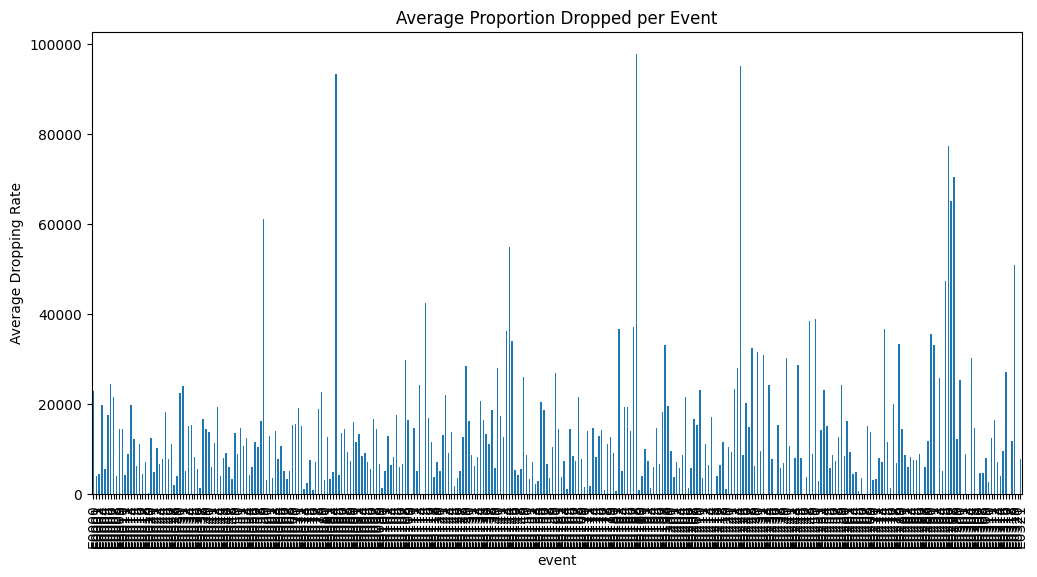

In [5]:
## Races Dataset Analysis
# 1. Distribution of race-level properties: total_dist and total_dpos
plt.figure(figsize=(12, 6))
sns.histplot(races['total_dist'], kde=True, bins=30, color='blue', label='Total Distance')
sns.histplot(races['total_dpos'], kde=True, bins=30, color='orange', label='Total Dpos', alpha=0.7)
plt.title("Distribution of Total Distance and Positive Difficulty")
plt.legend()
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

# 2. Correlation between distance and difficulty
corr = races[['total_dist', 'total_dpos']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix: Total Distance vs Positive Difficulty")
plt.show()

# 3. Average dropping rate (proportion of dropped participants) per event
avg_prop_dropped = races.groupby('event')['prop_dropped'].mean()
avg_prop_dropped.plot(kind='bar', figsize=(12, 6), title="Average Proportion Dropped per Event")
plt.ylabel("Average Dropping Rate")
plt.show()

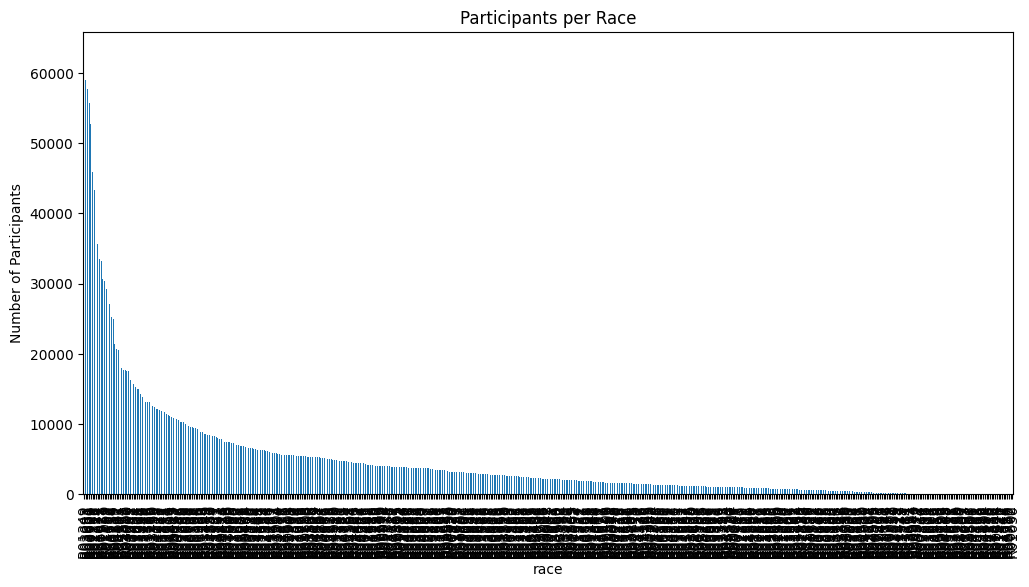

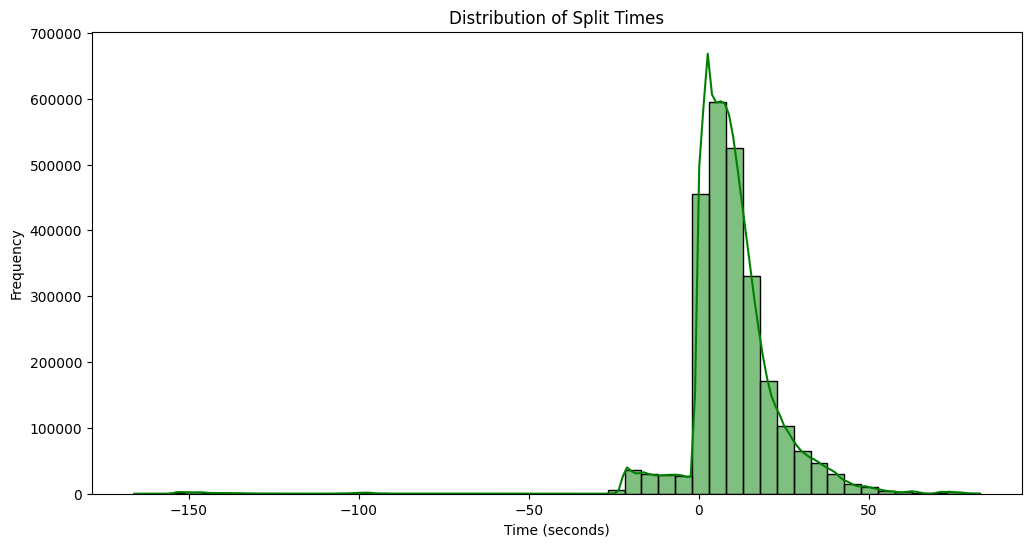

In [6]:
## Splits Dataset Analysis
# 4. Number of participants per race
participants_per_race = splits['race'].value_counts()
participants_per_race.plot(kind='bar', figsize=(12, 6), title="Participants per Race")
plt.ylabel("Number of Participants")
plt.show()

# 5. Distribution of split times
plt.figure(figsize=(12, 6))
sns.histplot(splits['time'], kde=True, bins=50, color='green')
plt.title("Distribution of Split Times")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()

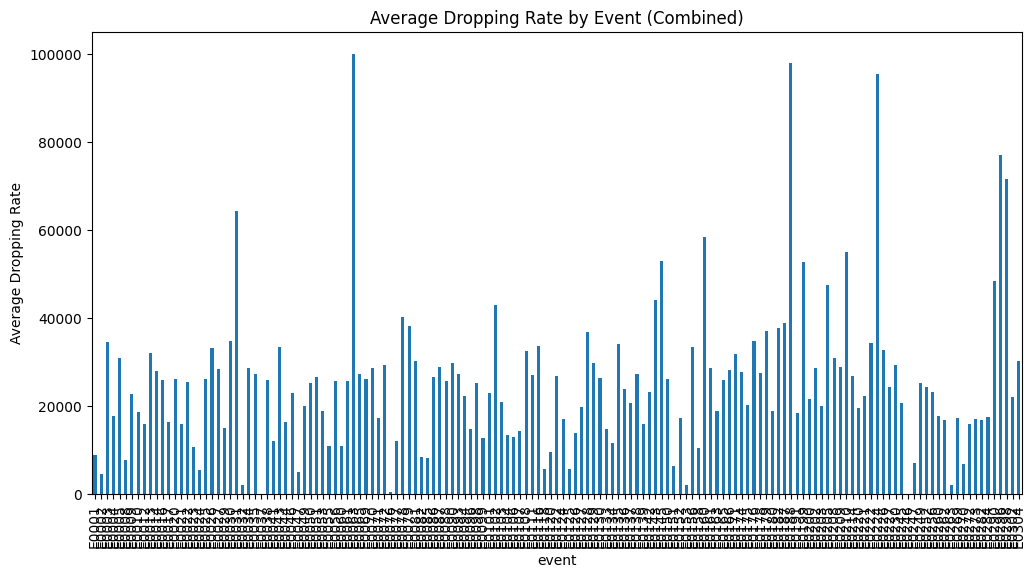

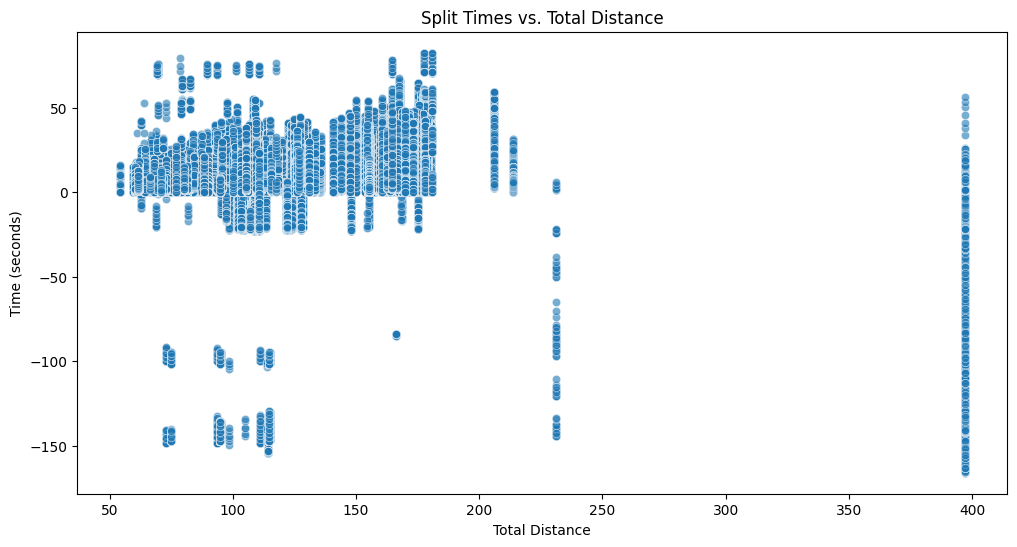

In [7]:
# Combined Dataset Analysis
# Merge datasets on `race`
combined_data = splits.merge(races, on='race', how='inner')

# 6. Average dropping rate by event in combined data
avg_dropped_combined = combined_data.groupby('event')['prop_dropped'].mean()
avg_dropped_combined.plot(kind='bar', figsize=(12, 6), title="Average Dropping Rate by Event (Combined)")
plt.ylabel("Average Dropping Rate")
plt.show()

# 7. Split times vs. total distance
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_data, x='total_dist', y='time', alpha=0.6)
plt.title("Split Times vs. Total Distance")
plt.xlabel("Total Distance")
plt.ylabel("Time (seconds)")
plt.show()

## **Model**

This part shows the step by step process necessary to create a Bayesian Network.

### **Clustering Process Explanation**

The goal of this section is to group races into clusters based on their difficulty. We achieve this using **Gaussian Mixture Models (GMM)**, with the number of clusters selected using the **Bayesian Information Criterion (BIC)**.

#### Steps done 
1. **Feature Selection and Normalization**:
   - Selected race-specific features: `total_dist`, `total_dpos`, `min_alt`, `mean_alt`, `max_alt`
   - Normalized these features using `StandardScaler` to bring them to the same scale. This is necessary because GMM relies on distance metrics.

2. **Optimal Cluster Selection with BIC**:
   - Tested different numbers of clusters (`n_components` from 1 to 9) and calculated the **BIC** score for each.
   - Chose the optimal number of clusters with a low BIC value, which balances model complexity and fit to the data.

3. **Fitting the Gaussian Mixture Model**:
   - Fit the GMM model using the selected number of clusters.
   - Assigned each race to a cluster based on the model's predictions.

4. **Cluster Analysis**:
   - Visualized the clusters in a 2D scatter plot, using `total_dist` and `total_dpos` as the axes.
   - Summarized each cluster’s characteristics by calculating the average values of the selected features.

#### **Bayesian Information Criterion (BIC)**
- BIC evaluates the tradeoff between model complexity (number of parameters) and model fit (log-likelihood of the data given the model).
- **Formula**:
  $$
  \text{BIC} = k \cdot \ln(n) - 2 \cdot \ln(\hat{L})
  $$
  Where:
  - $k$: Number of parameters in the model.
  - $n$: Number of data points.
  - $\ln(\hat{L})$: Log-likelihood of the model.

In [11]:
# Select features for clustering
features = ['total_dist', 'total_dpos', 'min_alt', 'mean_alt', 'max_alt']

# Normalize the features to ensure they're on the same scale
scaler = StandardScaler()
races_scaled = scaler.fit_transform(races[features])

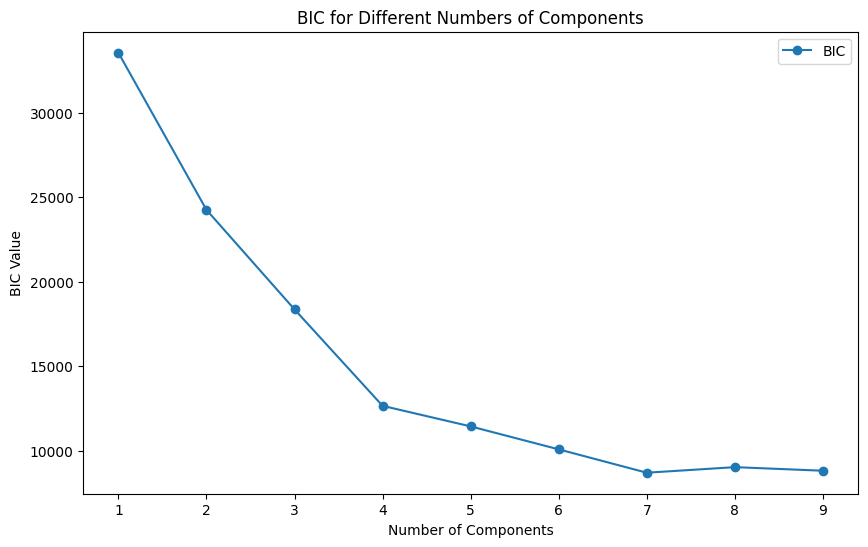

Optimal number of components (BIC): 7


In [12]:
bic = []
n_components_range = range(1, 10)  # Test from 1 to 9 components

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(races_scaled)
    bic.append(gmm.bic(races_scaled))

# Plot BIC values
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.title("BIC for Different Numbers of Components")
plt.xlabel("Number of Components")
plt.ylabel("BIC Value")
plt.legend()
plt.show()

# Select the optimal number of components based on BIC
optimal_components = n_components_range[np.argmin(bic)]
print(f"Optimal number of components (BIC): {optimal_components}")

#### **Gaussian Mixture Models (GMM)**
- GMM assumes the data is generated from a mixture of Gaussian distributions, each representing a cluster.
- **Probability Density Function (PDF)**:
  $$
  P(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x | \mu_k, \Sigma_k)
  $$
  Where:
  - $K$: Number of clusters.
  - $\pi_k$: Mixing coefficient (proportion of data points in cluster $k$).
  - $\mathcal{N}(x | \mu_k, \Sigma_k)$: Gaussian distribution for cluster $k$, defined by mean $\mu_k$ and covariance $\Sigma_k$.

- **Cluster Assignment**: Each data point is assigned to the cluster with the highest posterior probability.

Cluster Means (Scaled):
[[ 0.01140143 -0.68579447 -0.98338962 -1.21070644 -1.27233377]
 [ 1.04214629  1.02665681 -0.18456602  0.22950283  0.47733269]
 [-0.38953847 -0.20279935  0.38651443  0.34503718  0.3085985 ]
 [-0.90698876 -0.7207092   0.22834852 -0.22310862 -0.53332973]]


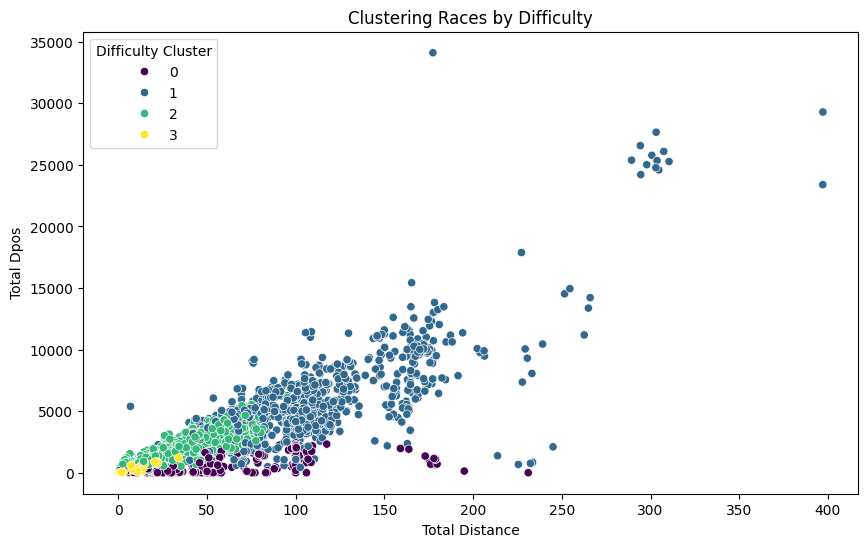

Cluster Characteristics (Original Scale):
                    total_dist   total_dpos     min_alt     mean_alt  \
difficulty_cluster                                                     
0                    53.259039   580.208696   13.682609     37.55942   
1                   103.587865   5506.70787  447.011924  1018.211844   
2                    35.911713  1905.762418  758.808831  1079.477923   
3                    12.569296   487.948454  696.351988   721.210604   

                        max_alt  
difficulty_cluster               
0                     67.543478  
1                   1695.493641  
2                    1507.29704  
3                    761.469809  


In [13]:
# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=4, random_state=42)
races['difficulty_cluster'] = gmm.fit_predict(races_scaled)

# Analyze Results
print("Cluster Means (Scaled):")
print(gmm.means_)  # Scaled means for each cluster

# Visualize Clusters in a 2D Space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=races['total_dist'], 
    y=races['total_dpos'], 
    hue=races['difficulty_cluster'], 
    palette="viridis"
)
plt.title("Clustering Races by Difficulty")
plt.xlabel("Total Distance")
plt.ylabel("Total Dpos")
plt.legend(title="Difficulty Cluster")
plt.show()

# Summarize Cluster Characteristics
cluster_summary = races.groupby('difficulty_cluster')[features].mean()
print("Cluster Characteristics (Original Scale):")
print(cluster_summary)

### **Plots**

1. **Proportion Dropped by Difficulty Cluster:**
A boxplot showing the distribution of `prop_dropped` (proportion of participants who dropped out) across different `difficulty_cluster` groups.

2. **Average Number of Participants Started by Difficulty Cluster**
A bar chart showing the average number of participants (`nb_started`) for each difficulty cluster.

3. **Participant Time Distribution by Difficulty Cluster**
A boxplot showing the distribution of participant completion times (`time`) across difficulty clusters.

4. **Distance Covered by Participants Across Difficulty Clusters**
A boxplot showing the distribution of distances (`dist`) covered by participants across difficulty clusters.

5. **Average Participant Performance by Cluster**
A table summarizing average participant performance, specifically:
  - `time`: Average completion time for participants.
  - `dist`: Average distance covered by participants.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\aleca\AppData\Local\Temp\ipykernel_15172\2826527166.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=races, x='difficulty_cluster', y='prop_dropped', palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


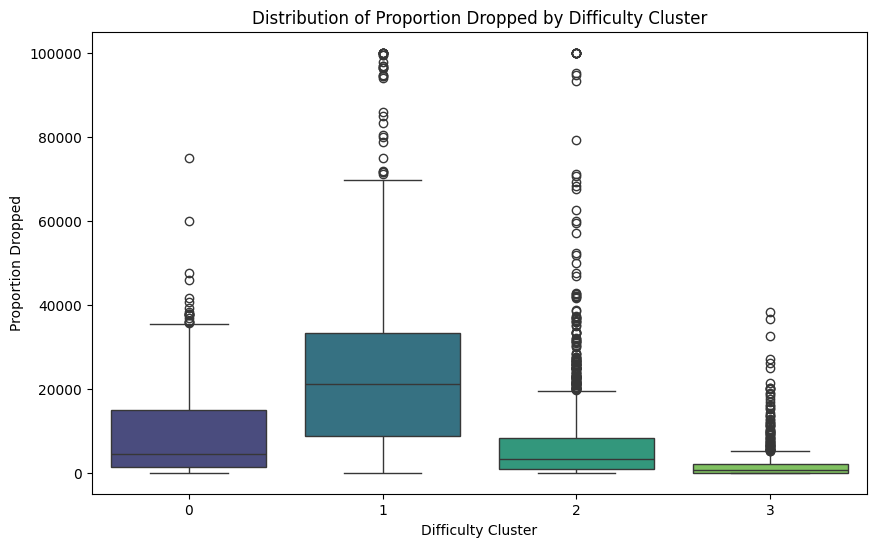

Average Number of Participants Started by Difficulty Cluster:
difficulty_cluster
0    471.472464
1    470.176471
2    419.903663
3    343.094256
Name: nb_started, dtype: float64


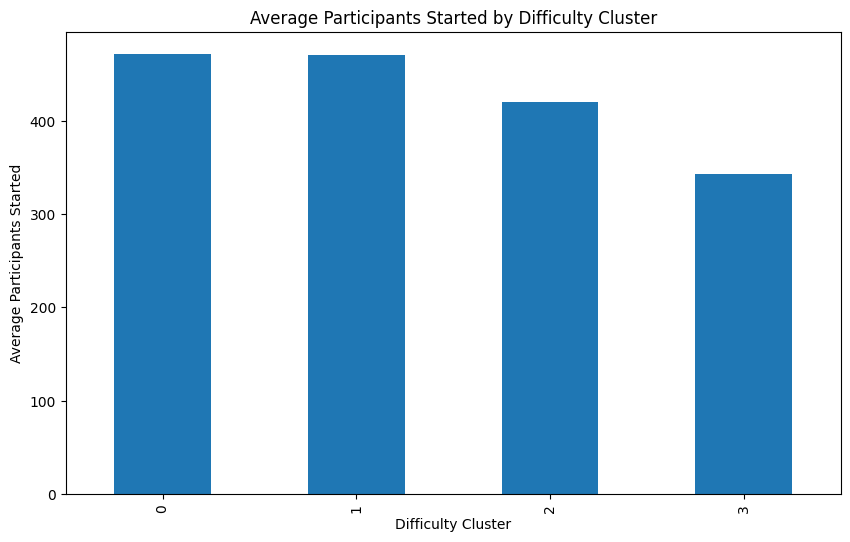

In [14]:
# 1. Visualize the distribution of prop_dropped across difficulty clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=races, x='difficulty_cluster', y='prop_dropped', palette='viridis')
plt.title("Distribution of Proportion Dropped by Difficulty Cluster")
plt.xlabel("Difficulty Cluster")
plt.ylabel("Proportion Dropped")
plt.show()

# Analyze the average number of participants started per difficulty cluster
participants_started = races.groupby('difficulty_cluster')['nb_started'].mean()
print("Average Number of Participants Started by Difficulty Cluster:")
print(participants_started)

# 2. Plot average participants startedr
participants_started.plot(kind='bar', figsize=(10, 6), title="Average Participants Started by Difficulty Cluster")
plt.xlabel("Difficulty Cluster")
plt.ylabel("Average Participants Started")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\aleca\AppData\Local\Temp\ipykernel_10352\1294115103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='difficulty_cluster', y='time', palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


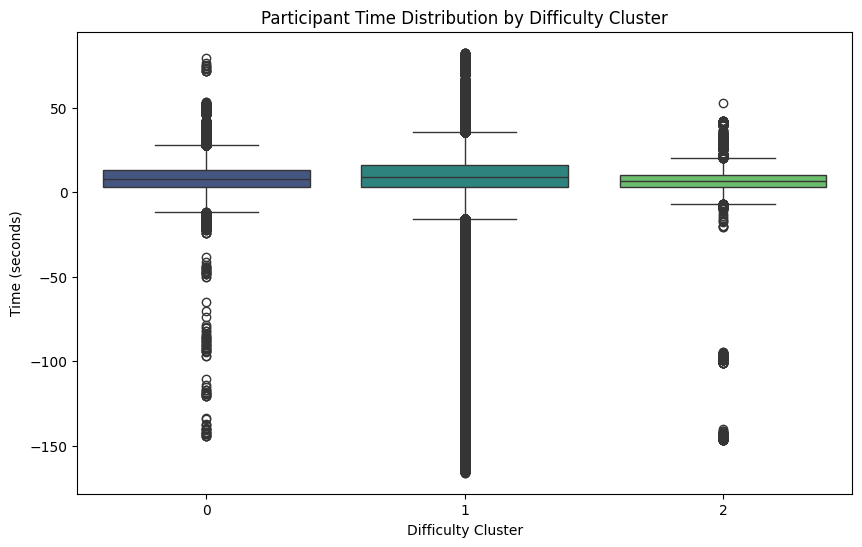

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\aleca\AppData\Local\Temp\ipykernel_10352\1294115103.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='difficulty_cluster', y='dist', palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


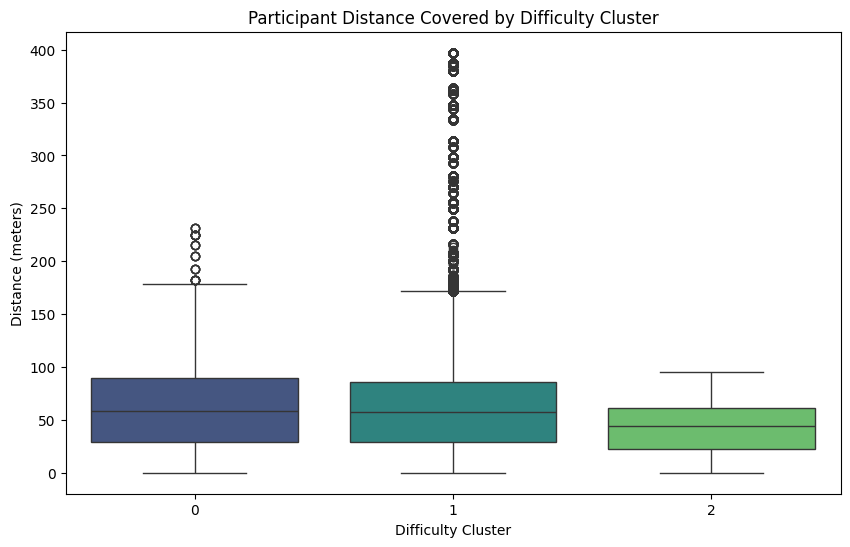

Average Participant Performance by Difficulty Cluster:
                         time       dist
difficulty_cluster                      
0                    8.969761  63.924242
1                   10.011320  61.184048
2                    6.889254  41.860618


In [12]:
# Merge difficulty_cluster into splits dataset
combined_data = splits.merge(races[['race', 'difficulty_cluster']], on='race', how='inner')

# 3. Analyze participant time distribution across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='difficulty_cluster', y='time', palette='viridis')
plt.title("Participant Time Distribution by Difficulty Cluster")
plt.xlabel("Difficulty Cluster")
plt.ylabel("Time (seconds)")
plt.show()

# 4. Analyze distance covered by participants across difficulty clusters
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='difficulty_cluster', y='dist', palette='viridis')
plt.title("Participant Distance Covered by Difficulty Cluster")
plt.xlabel("Difficulty Cluster")
plt.ylabel("Distance (meters)")
plt.show()

# 5. Summarize average participant performance by cluster
performance_summary = combined_data.groupby('difficulty_cluster')[['time', 'dist']].mean()
print("Average Participant Performance by Difficulty Cluster:")
print(performance_summary)

### **Bayesian Modeling**

This block of code creates a **Bayesian Network** to model the relationships between race difficulty (`difficulty_cluster`), dropout rates (`prop_dropped`), and participant completion times (`time`). 

#### **What is a Bayesian Network?**
A **Bayesian Network** (BN) is a probabilistic graphical model that represents a set of variables and their conditional dependencies using a directed acyclic graph (DAG). 

In a Bayesian Network:
- **Nodes** represent random variables (e.g., `difficulty_cluster`, `prop_dropped`, `time`).
- **Directed Edges** represent conditional dependencies between variables. For example:
  - `difficulty_cluster → prop_dropped` means that the dropout rate depends on the race difficulty.

### Mathematical Representation
The Bayesian Network encodes the joint probability distribution (JPD) of the variables as a product of conditional probabilities:

$$
P(X_1, X_2, \dots, X_n) = \prod_{i=1}^n P(X_i \mid \text{Parents}(X_i))
$$

Where:
- $X_i$: A random variable in the network.
- $\text{Parents}(X_i)$: The set of variables that have directed edges pointing to $X_i$.

For this specific model:
$$
P(\text{difficulty\_cluster}, \text{prop\_dropped}, \text{time}) = P(\text{difficulty\_cluster}) \cdot P(\text{prop\_dropped} \mid \text{difficulty\_cluster}) \cdot P(\text{time} \mid \text{prop\_dropped})
$$

#### **Purpose of a Bayesian Network**
The code calculates the probability distribution of participant completion times (`Short`, `Medium`, `Long`) for each difficulty cluster (`Cluster0`, `Cluster1`, etc.) using the Bayesian Network. This helps quantify how race difficulty impacts completion times, allowing for data-driven analysis of participant performance.

In [15]:
# Merge difficulty_cluster and prop_dropped into splits dataset
combined_data = splits.merge(
    races[['race', 'difficulty_cluster', 'prop_dropped']], 
    on='race', 
    how='inner'
)

# Simplify data for Bayesian modeling
bayesian_data = combined_data[['difficulty_cluster', 'prop_dropped', 'time']].copy()

# Discretize continuous variables (time and prop_dropped)
# Binning 'prop_dropped' into Low, Medium, High based on quantiles
bayesian_data['prop_dropped'] = pd.qcut(bayesian_data['prop_dropped'], q=3, labels=['Low', 'Medium', 'High'])

# Threshold-based binning for 'time'
time_bins = [0, 2, 3.5, 4.1]  # Adjust these thresholds based on your dataset
bayesian_data['time'] = pd.cut(
    bayesian_data['time'], 
    bins=time_bins, 
    labels=['Short', 'Medium', 'Long'], 
    include_lowest=True
)

# Verify the binning
print("Binned 'time' distribution:")
print(bayesian_data['time'].value_counts())

# Convert difficulty_cluster into categorical labels
difficulty_labels = {0: 'Cluster0', 1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3'}
bayesian_data['difficulty_cluster'] = bayesian_data['difficulty_cluster'].map(difficulty_labels)

Binned 'time' distribution:
time
Short     300521
Medium    210069
Long       67589
Name: count, dtype: int64


In [16]:
# Define and fit the Bayesian Network
model = BayesianNetwork([
    ('difficulty_cluster', 'prop_dropped'),
    ('difficulty_cluster', 'time'),  # Added dependency
    ('prop_dropped', 'time')
])

# Fit the model
model.fit(bayesian_data, estimator=MaximumLikelihoodEstimator)

# Perform inference
inference = VariableElimination(model)

clusters = bayesian_data['difficulty_cluster'].unique()

# Perform inference for all difficulty clusters and display the results dynamically
for cluster in clusters:
    query_result = inference.query(
        variables=['time'], 
        evidence={'difficulty_cluster': cluster}
    )
    print(f"Probability of participant time being 'Long', 'Medium', or 'Short' given difficulty cluster {cluster}:")
    print(query_result)
    print("\n" + "-"*50 + "\n")

Probability of participant time being 'Long', 'Medium', or 'Short' given difficulty cluster Cluster2:
+--------------+-------------+
| time         |   phi(time) |
+==============+=============+
| time(Long)   |      0.1274 |
+--------------+-------------+
| time(Medium) |      0.3959 |
+--------------+-------------+
| time(Short)  |      0.4767 |
+--------------+-------------+

--------------------------------------------------

Probability of participant time being 'Long', 'Medium', or 'Short' given difficulty cluster Cluster1:
+--------------+-------------+
| time         |   phi(time) |
+==============+=============+
| time(Long)   |      0.1170 |
+--------------+-------------+
| time(Medium) |      0.3655 |
+--------------+-------------+
| time(Short)  |      0.5176 |
+--------------+-------------+

--------------------------------------------------

Probability of participant time being 'Long', 'Medium', or 'Short' given difficulty cluster Cluster0:
+--------------+-------------+

### **Gibbs Sampling**

Gibbs Sampling is a type of **Markov Chain Monte Carlo (MCMC)** method used to generate samples from a joint probability distribution when direct sampling is computationally challenging. It simplifies the process by iteratively sampling each variable while conditioning on the current values of all other variables.


#### **Mathematical Definition**
Given a joint probability distribution $P(X_1, X_2, \dots, X_n)$ over variables $X_1, X_2, \dots, X_n$, Gibbs Sampling generates samples as follows:

1. Initialize all variables $X_1, X_2, \dots, X_n$ with some random values.

2. For each variable $X_i$, sample from its **conditional distribution**:
   $$
   X_i^{(t+1)} \sim P(X_i \mid X_1^{(t+1)}, \dots, X_{i-1}^{(t+1)}, X_{i+1}^{(t)}, \dots, X_n^{(t)})
   $$
   Here, $X_i^{(t+1)}$ is updated based on the most recent values of the other variables.

3. Repeat this process for a specified number of iterations to generate samples.

In this project, Gibbs Sampling is used to:

1. **Infer Posterior Distributions**:
   - It approximates the joint and marginal distributions of variables like `difficulty_cluster`, `prop_dropped`, and `time`.
   - This helps quantify the uncertainty in these variables given the structure of the Bayesian Network.

2. **Explore Conditional Dependencies**:
   - By iteratively sampling, Gibbs Sampling captures the relationships between variables, such as how `difficulty_cluster` influences `prop_dropped` and `time`.

In [17]:
def gibbs_sampling(data, num_iterations=1000):
    samples = []
    
    # Initialize variables randomly
    current_state = {
        'difficulty_cluster': random.choice(data['difficulty_cluster'].unique()),
        'prop_dropped': random.choice(data['prop_dropped'].unique()),
        'time': random.choice(data['time'].unique())
    }

    for _ in range(num_iterations):
        # Sample difficulty_cluster given prop_dropped and time
        sampled_cluster = inference.query(
            variables=['difficulty_cluster'],
            evidence={'prop_dropped': current_state['prop_dropped'], 'time': current_state['time']}
        )
        current_state['difficulty_cluster'] = random.choices(
            population=sampled_cluster.state_names['difficulty_cluster'],
            weights=sampled_cluster.values
        )[0]
        
        # Sample prop_dropped given difficulty_cluster and time
        sampled_prop_dropped = inference.query(
            variables=['prop_dropped'],
            evidence={'difficulty_cluster': current_state['difficulty_cluster'], 'time': current_state['time']}
        )
        current_state['prop_dropped'] = random.choices(
            population=sampled_prop_dropped.state_names['prop_dropped'],
            weights=sampled_prop_dropped.values
        )[0]
        
        # Sample time given difficulty_cluster and prop_dropped
        sampled_time = inference.query(
            variables=['time'],
            evidence={'difficulty_cluster': current_state['difficulty_cluster'], 'prop_dropped': current_state['prop_dropped']}
        )
        current_state['time'] = random.choices(
            population=sampled_time.state_names['time'],
            weights=sampled_time.values
        )[0]
        
        # Save the current state
        samples.append(current_state.copy())
    
    return samples

# Run Gibbs Sampling
gibbs_samples = gibbs_sampling(bayesian_data, num_iterations=1000)

# Analyze Results
print(f"First 10 Gibbs samples:\n{gibbs_samples[:10]}")


First 10 Gibbs samples:
[{'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Long'}, {'difficulty_cluster': 'Cluster0', 'prop_dropped': 'High', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster2', 'prop_dropped': 'Low', 'time': 'Long'}, {'difficulty_cluster': 'Cluster2', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Long'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Short'}]


#### **Interpretation of Gibbs Sampling Results**

#### **1. Joint State Frequencies**
The most frequent state is `('Cluster1', 'High', 'Short')`, accounting for 18% of the samples. This suggests that **Cluster1** represents challenging races where participants often drop out early but finish quickly if they complete the race. Similarly:
- `('Cluster1', 'Medium', 'Short')` (16%) and `('Cluster1', 'Low', 'Short')` (12%) reinforce this trend.
- **Cluster2** primarily associates with `Low` dropout rates, but it is less frequent in the dataset.
- Rare states like `('Cluster0', 'High', 'Long')` or `('Cluster2', 'High', 'Medium')` occur with negligible frequency, suggesting these scenarios are uncommon.

#### **2. Marginal Proportions for Difficulty Clusters**
The marginal proportions of difficulty clusters are:
- **Cluster1**: 84% (dominates the dataset).
- **Cluster2**: 10% (moderately represented, easier races).
- **Cluster0**: 6% (rare, possibly edge cases or outliers).

This indicates that most races fall into **Cluster1**, which likely corresponds to races with higher dropout rates and shorter times.

#### **3. Overall Observations**
- **Relationships**: High dropout rates (`prop_dropped = High`) correlate strongly with shorter completion times (`time = Short`) in Cluster1.
- **Cluster Trends**: Cluster2 represents races with low dropout rates (`prop_dropped = Low`), aligning with easier races.
- **Rare States**: Certain combinations (e.g., `('Cluster0', 'High', 'Long')`) occur rarely, reflecting unlikely scenarios in the dataset.

In [18]:
counts = Counter([tuple(sample.values()) for sample in gibbs_samples])
for state, freq in counts.items():
    print(f"State: {state}, Frequency: {freq}, Proportion: {freq / len(gibbs_samples):.2f}")

State: ('Cluster1', 'High', 'Long'), Frequency: 39, Proportion: 0.04
State: ('Cluster0', 'High', 'Medium'), Frequency: 3, Proportion: 0.00
State: ('Cluster1', 'High', 'Medium'), Frequency: 111, Proportion: 0.11
State: ('Cluster1', 'High', 'Short'), Frequency: 145, Proportion: 0.14
State: ('Cluster1', 'Medium', 'Short'), Frequency: 155, Proportion: 0.15
State: ('Cluster1', 'Low', 'Medium'), Frequency: 89, Proportion: 0.09
State: ('Cluster2', 'Low', 'Long'), Frequency: 17, Proportion: 0.02
State: ('Cluster2', 'Low', 'Medium'), Frequency: 39, Proportion: 0.04
State: ('Cluster1', 'Low', 'Short'), Frequency: 101, Proportion: 0.10
State: ('Cluster2', 'Low', 'Short'), Frequency: 42, Proportion: 0.04
State: ('Cluster0', 'Low', 'Medium'), Frequency: 10, Proportion: 0.01
State: ('Cluster1', 'Medium', 'Medium'), Frequency: 133, Proportion: 0.13
State: ('Cluster1', 'Medium', 'Long'), Frequency: 39, Proportion: 0.04
State: ('Cluster1', 'Low', 'Long'), Frequency: 21, Proportion: 0.02
State: ('Cluste

In [19]:
difficulty_marginal = Counter(sample['difficulty_cluster'] for sample in gibbs_samples)
for cluster, freq in difficulty_marginal.items():
    print(f"Cluster: {cluster}, Proportion: {freq / len(gibbs_samples):.2f}")


Cluster: Cluster1, Proportion: 0.83
Cluster: Cluster0, Proportion: 0.06
Cluster: Cluster2, Proportion: 0.11


### **Aleatoric Uncertainty (Split-Time Variability)**

Uncertainty in a model represents the degree of doubt in its predictions. It can arise due to randomness in the data or limitations in the model itself. Measuring uncertainty helps quantify confidence in predictions and identify areas requiring further attention.

Aleatoric uncertainty reflects the inherent randomness in the data, specifically the variability of participant split times within each race. Larger values indicate races with high variability, suggesting more diverse or unpredictable participant performances.

In [48]:
aleatoric_uncertainty = combined_data.groupby('race')['time'].std()
print("Aleatoric Uncertainty (Split-Time Variability):")
print(aleatoric_uncertainty)

predicted_time = inference.query(
    variables=['time'], 
    evidence={'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High'}
)
print(predicted_time)  # Check the variance in the probability distribution

Aleatoric Uncertainty (Split-Time Variability):
race
R00001     4.173825
R00002    56.524128
R00003     4.941352
R00004     5.481255
R00005     5.877809
            ...    
R04559     9.307239
R04565     5.568199
R04591    26.144111
R04607     3.200505
R04610    12.987514
Name: time, Length: 542, dtype: float64
+--------------+-------------+
| time         |   phi(time) |
+==============+=============+
| time(Long)   |      0.1104 |
+--------------+-------------+
| time(Medium) |      0.3797 |
+--------------+-------------+
| time(Short)  |      0.5099 |
+--------------+-------------+


### **Epistemic Uncertainty (Chain Variability from Gibbs Sampling)**

Epistemic uncertainty, also known as model uncertainty, arises from limited knowledge or insufficient data. It reflects uncertainty in the model's understanding of the underlying process and can be reduced by improving the model or gathering more data. Epistemic uncertainty is crucial for assessing the model's reliability and areas where its predictions are less confident.

Epistemic uncertainty measures the model's uncertainty due to limited knowledge or data. Multiple Gibbs sampling chains reveal how consistent the model's predictions are.

In [ ]:
bayesian_data['difficulty_cluster'] = bayesian_data['difficulty_cluster'].fillna(bayesian_data['difficulty_cluster'].mode()[0])
bayesian_data['prop_dropped'] = bayesian_data['prop_dropped'].fillna(bayesian_data['prop_dropped'].mode()[0])
bayesian_data['time'] = bayesian_data['time'].fillna(bayesian_data['time'].mode()[0])

num_chains = 5
all_samples = []
for chain in range(num_chains):
    gibbs_samples = gibbs_sampling(bayesian_data, num_iterations=1000)
    all_samples.append(gibbs_samples)

# Analyze variability between chains
for chain_idx, samples in enumerate(all_samples):
    print(f"Chain {chain_idx+1}: {samples[:10]}")

Chain 1: [{'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster0', 'prop_dropped': 'Medium', 'time': 'Short'}, {'difficulty_cluster': 'Cluster0', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster2', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Medium'}]
Chain 2: [{'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Short'}, {'difficulty_cluster': 'Cluster2', 'prop_droppe

### **Latent Representation Learning with Autoencoders**

Autoencoders are a powerful tool for learning **latent representations** of high-dimensional data. These representations allow us to compress and summarize data into a lower-dimensional space while retaining meaningful patterns and structures.

#### **Latent Representation**

Latent representations are compact, hidden features that describe the underlying structure of data. In this project, we aim to capture the **essential features of participant data** (such as time, distance, altitude, etc.) in a low-dimensional space, enabling us to explore intrinsic properties and relationships.

### **Autoencoder**

An **Autoencoder** is a type of neural network designed to learn a compressed latent representation of data by reconstructing its input. It achieves this by minimizing the difference between the original input and its reconstruction. Autoencoders consist of two main components:

- **Encoder**: Maps the high-dimensional input data $x$ to a lower-dimensional latent representation $z$ in the latent space.
- **Decoder**: Reconstructs the input $\hat{x}$ from the latent representation $z$.


#### **Mathematical Definition**

**Encoder**:  
The encoder maps the input $x \in \mathbb{R}^n$ to a latent representation $z \in \mathbb{R}^m$, where $m < n$, using a function $f_{\text{encoder}}$:
$$
z = f_{\text{encoder}}(x; \theta_{\text{encoder}})
$$
where $\theta_{\text{encoder}}$ are the parameters (weights and biases) of the encoder network.

**Decoder**:  
The decoder reconstructs the input $\hat{x} \in \mathbb{R}^n$ from the latent representation $z$, using a function $f_{\text{decoder}}$:
$$
\hat{x} = f_{\text{decoder}}(z; \theta_{\text{decoder}})
$$
where $\theta_{\text{decoder}}$ are the parameters of the decoder network.

**Reconstruction Loss**:  
The goal of the autoencoder is to minimize the reconstruction loss, which measures the difference between the original input $x$ and the reconstruction $\hat{x}$. A common choice for the reconstruction loss is the Mean Squared Error (MSE):
$$
\mathcal{L}_{\text{reconstruction}} = \frac{1}{n} \sum_{i=1}^n \| x_i - \hat{x}_i \|^2
$$
Alternatively, other loss functions like Binary Cross-Entropy (BCE) can be used for specific applications.


#### **Purpose in This Project**

In this project, the Autoencoder was used to:
- Learn a **latent representation** of participant performance data (e.g., `time`, `dist`, `dpos`, etc.).
- Reduce the dimensionality of the data while preserving meaningful relationships and patterns.
- Analyze and visualize the latent space to uncover underlying structures in the participant and race data.

In [18]:
# Merge splits and race-specific features
races_features = races[['race', 'difficulty_cluster', 'prop_dropped']]
combined_data = splits.merge(races_features, on='race', how='inner')

# Prepare input data
splits_numeric = combined_data[['finish', 'dist', 'dpos', 'alt', 'time', 'difficulty_cluster', 'prop_dropped']]

# Normalize the data
scaler = MinMaxScaler()
splits_scaled = scaler.fit_transform(splits_numeric)

# Convert to PyTorch tensors
splits_tensor = torch.tensor(splits_scaled, dtype=torch.float32)

In [19]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Reduce to latent dimensions
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),  # Reconstruct to original dimensions
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [20]:
# Hyperparameters
input_dim = splits_scaled.shape[1]  # Updated with the new number of features
latent_dim = 2  # Keep 2 dimensions for visualization
batch_size = 64
epochs = 50
learning_rate = 0.001

# Training loop with early stopping
patience = 5 
min_delta = 1e-4
best_loss = float('inf')  
wait = 0 

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset and DataLoader
dataset = TensorDataset(splits_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
autoencoder = Autoencoder(input_dim, latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

Using device: cuda


In [75]:
for epoch in range(epochs):
    autoencoder.train()
    epoch_loss = 0.0

    for data in dataloader:
        inputs = data[0].to(device)
        encoded, decoded = autoencoder(inputs)
        loss = criterion(decoded, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    # Early stopping check
    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        wait = 0  # Reset patience counter if there is an improvement
    else:
        wait += 1  # Increment patience counter if no improvement

    if wait >= patience:  # Stop training if patience threshold is exceeded
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Epoch [1/50], Loss: 0.002094
Epoch [2/50], Loss: 0.001360
Epoch [3/50], Loss: 0.001273
Epoch [4/50], Loss: 0.001214
Epoch [5/50], Loss: 0.001157
Epoch [6/50], Loss: 0.001120
Epoch [7/50], Loss: 0.001077
Epoch [8/50], Loss: 0.001036
Epoch [9/50], Loss: 0.001012
Epoch [10/50], Loss: 0.000994
Epoch [11/50], Loss: 0.000980
Epoch [12/50], Loss: 0.000967
Epoch [13/50], Loss: 0.000955
Epoch [14/50], Loss: 0.000946
Epoch [15/50], Loss: 0.000934
Epoch [16/50], Loss: 0.000925
Epoch [17/50], Loss: 0.000920
Early stopping triggered at epoch 17.


#### Save the model

In [76]:
torch.save(autoencoder.state_dict(), 'autoencoder_model2.pth')

#### Load the model

In [21]:
autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.load_state_dict(torch.load('autoencoder_model2.pth'))
autoencoder.to(device)  # Move to GPU if available
autoencoder.eval()  # Set the model to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
    (3): Sigmoid()
  )
)

#### **Latent Features of Participants**

This plot shows the **latent space** learned by the autoencoder, compressing participants' performance data into two dimensions: **Latent Dimension 1** and **Latent Dimension 2**. 

#### **Key Observations**:
1. **Clusters**:
   - Participants with similar performance characteristics are grouped closely.
   - A distinct **purple cluster** represents top performers (lower finish positions).

2. **Color (Finish Position)**:
   - **Purple**: Better finish positions.
   - **Yellow**: Weaker performances, with more variability.


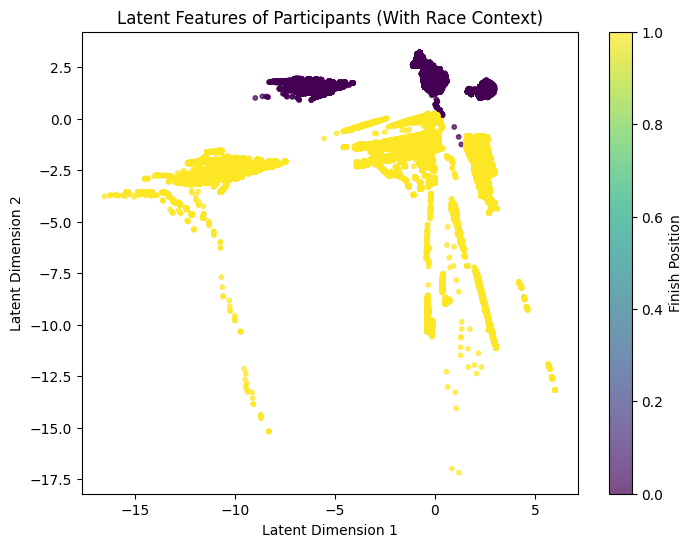

In [22]:
# Extract latent features
autoencoder.eval()
with torch.no_grad():
    latent_features, _ = autoencoder(splits_tensor.to(device))
    latent_features = latent_features.cpu().numpy()  # Move back to CPU for visualization

# Scatter plot of latent features
plt.figure(figsize=(8, 6))
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=combined_data['finish'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Finish Position')
plt.title("Latent Features of Participants (With Race Context)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

#### **Descriptions for the Three Images**

#### **1. Correlation Heatmap**
Shows how latent dimensions relate to original features (`finish`, `dist`, `dpos`, `alt`, `time`).
**Key Observations**:
- Latent Dimension 1 strongly correlates with `finish` (0.74) and `alt` (0.52).
- Latent Dimension 2 is negatively correlated with `alt` (-0.68) and `dpos` (-0.39).

#### **2. Clusters in Latent Space**
Visualizes participants grouped into 4 clusters in the 2D latent space.
**Key Observations**:
- Distinct clusters indicate participants with similar performance characteristics.
- Well-separated groups suggest meaningful latent features.

#### **3. Cluster Feature Summary**
Shows the average values of original features for each cluster.
**Key Observations**:
- Clusters reveal differences in performance metrics like `finish` and `alt`.
- Stronger performers (Cluster 2) have lower `finish` and higher `alt` values.
- Links latent clusters to real-world participant traits.


In [23]:
# Create a DataFrame for latent features and original features
latent_df = pd.DataFrame(latent_features, columns=['Latent1', 'Latent2'])
original_features_df = pd.DataFrame(splits_scaled, columns=['finish', 'dist', 'dpos', 'alt', 'time', 'difficulty_cluster', 'prop_dropped'])

# Combine both for correlation analysis
combined_df = pd.concat([latent_df, original_features_df], axis=1)

Correlation of Latent Dimensions with Original Features:
           finish      dist      dpos       alt      time  difficulty_cluster  \
Latent1 -0.069080 -0.172743  0.141371  0.411311 -0.099158            0.832061   
Latent2 -0.881673 -0.047898  0.087407  0.271482  0.122570           -0.015410   

         prop_dropped  
Latent1     -0.034690  
Latent2      0.473088  


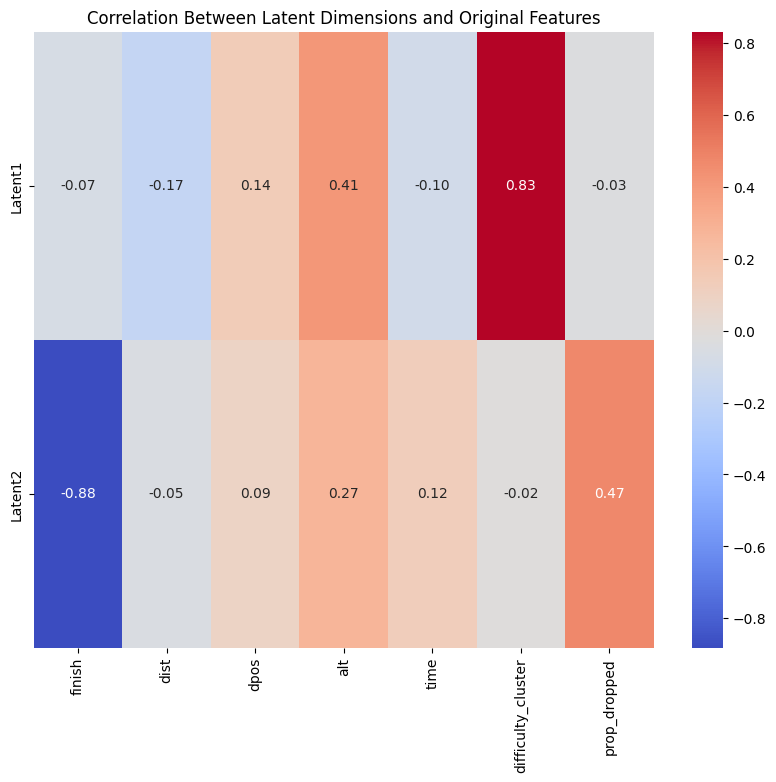

In [24]:
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Extract correlations of latent dimensions with original features
latent_correlation = correlation_matrix.loc[['Latent1', 'Latent2'], ['finish', 'dist', 'dpos', 'alt', 'time', 'difficulty_cluster', 'prop_dropped']]
print("Correlation of Latent Dimensions with Original Features:")
print(latent_correlation)

# Visualize correlations as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(latent_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Latent Dimensions and Original Features")
plt.show()

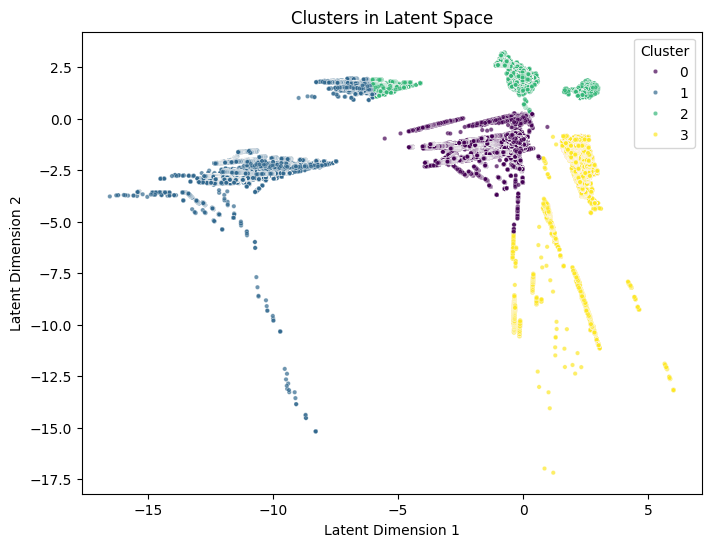

In [22]:
# Apply k-means clustering to the latent space
n_clusters = 4  # Choose the number of clusters (adjustable)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_features)

# Add cluster assignments to the latent DataFrame
latent_df['Cluster'] = clusters

# Visualize clusters in the latent space
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Latent1', y='Latent2', hue='Cluster', palette='viridis', data=latent_df, s=10, alpha=0.7)
plt.title("Clusters in Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()

Cluster Summary (Mean of Original Features):
           finish      dist      dpos       alt      time  difficulty_cluster  \
Cluster                                                                         
0        0.999985  0.163993  0.127163  0.319349  0.713719            0.500000   
1        0.941613  0.168398  0.022891  0.014855  0.705852            0.000000   
2        0.000000  0.099247  0.080935  0.350772  0.691578            0.505705   
3        0.999992  0.110962  0.073787  0.247746  0.680667            0.986488   

         prop_dropped  
Cluster                
0            0.254362  
1            0.219728  
2            0.358024  
3            0.109909  


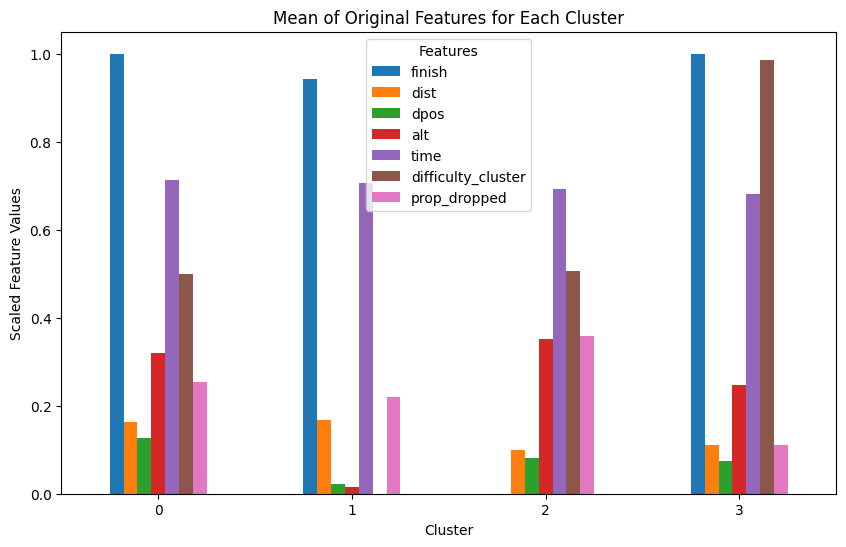

In [23]:
# Add cluster labels to the original features
original_features_df['Cluster'] = clusters

# Calculate the mean of original features for each cluster
cluster_summary = original_features_df.groupby('Cluster').mean()
print("Cluster Summary (Mean of Original Features):")
print(cluster_summary)

# Visualize the cluster summaries
cluster_summary.plot(kind='bar', figsize=(10, 6))
plt.title("Mean of Original Features for Each Cluster")
plt.ylabel("Scaled Feature Values")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Features")
plt.show()

#### **Latent Features per Race**

The purpose of this analysis was to:
- **Understand Latent Features**: Identify the relationship between the high-level, hidden patterns captured by the latent features and measurable race properties.
- **Interpret Race Characteristics**: Gain insights into how race properties like altitude, distance, and difficulty align with participant performance as represented by the latent features.
- **Validate the Model**: Assess whether the latent features extracted by the autoencoder provide meaningful representations that relate to real-world race attributes.

Pairwise Correlation Results:
   Correlation Latent Dimension Race Property
0    -0.095980          Latent1    total_dist
1     0.423413          Latent1    total_dpos
2     0.576441          Latent1      mean_alt
3     0.286973          Latent2    total_dist
4     0.486512          Latent2    total_dpos
5     0.255459          Latent2      mean_alt


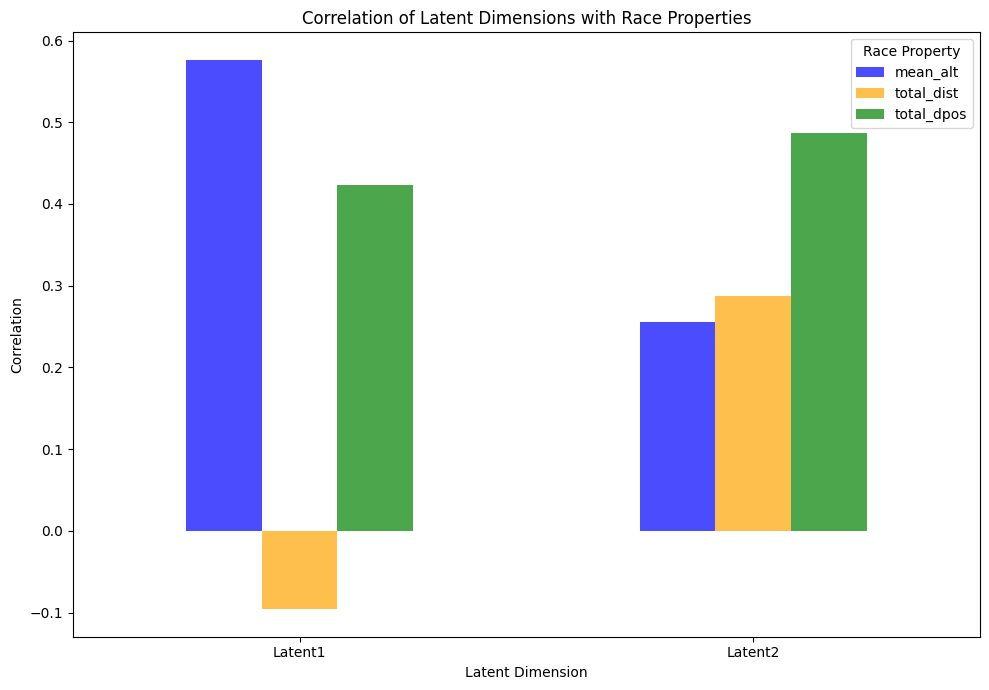

In [25]:
# Extract latent features for participants
latent_df = pd.DataFrame(latent_features, columns=['Latent1', 'Latent2'])
splits_with_latent = splits.copy()
splits_with_latent[['Latent1', 'Latent2']] = latent_df

# Ensure 'race' is numeric in splits_with_latent
if splits_with_latent['race'].dtype == 'object':
    splits_with_latent['race'] = splits_with_latent['race'].str.extract(r'(\d+)').astype(int)

# Aggregate latent features at the race level
aggregated_latent = splits_with_latent.groupby('race')[['Latent1', 'Latent2']].mean().reset_index()

# Ensure 'race' is numeric in races
if races['race'].dtype == 'object':
    races['race'] = races['race'].str.extract(r'(\d+)').astype(int)

# Filter races to include only those in latent features
races_filtered = races[races['race'].isin(aggregated_latent['race'])]

# Merge filtered races with latent features
combined_df = races_filtered.merge(aggregated_latent, on='race', how='inner')

scaler = StandardScaler()
combined_df[['total_dist', 'total_dpos', 'mean_alt']] = scaler.fit_transform(
    combined_df[['total_dist', 'total_dpos', 'mean_alt']]
)
combined_df[['Latent1', 'Latent2']] = scaler.fit_transform(combined_df[['Latent1', 'Latent2']])

# Explicitly calculate pairwise correlations
correlation_results = {}

for latent_col in ['Latent1', 'Latent2']:
    for race_col in ['total_dist', 'total_dpos', 'mean_alt']:
        correlation = combined_df[latent_col].corr(combined_df[race_col])
        correlation_results[(latent_col, race_col)] = correlation

# Convert results to DataFrame
correlation_df = pd.DataFrame.from_dict(
    correlation_results, orient='index', columns=['Correlation']
).reset_index()
correlation_df[['Latent Dimension', 'Race Property']] = pd.DataFrame(correlation_df['index'].tolist())
correlation_df = correlation_df.drop(columns='index')

# Display correlation results
print("Pairwise Correlation Results:")
print(correlation_df)

# Visualize the correlations
pivot_df = correlation_df.pivot(
    index='Latent Dimension', columns='Race Property', values='Correlation'
)
pivot_df.plot(kind='bar', figsize=(10, 7), color=['blue', 'orange', 'green'], alpha=0.7)
plt.title("Correlation of Latent Dimensions with Race Properties")
plt.ylabel("Correlation")
plt.xlabel("Latent Dimension")
plt.xticks(rotation=0)
plt.legend(title="Race Property", loc='upper right')
plt.tight_layout()
plt.show()

### **Variational Autoencoder (VAE)**

A Variational Autoencoder (VAE) is a probabilistic generative model that learns to encode input data into a latent space and reconstruct it back. Key components and mathematical definitions include:

#### **Encoder**
The encoder maps input data $x$ into the parameters of a latent distribution $q_\phi(z|x)$, typically a Gaussian:
$$
q_\phi(z|x) = \mathcal{N}(z; \mu_\phi(x), \Sigma_\phi(x))
$$
where:
- $\mu_\phi(x)$: Mean of the latent space.
- $\Sigma_\phi(x) = \text{diag}(\sigma_\phi^2(x))$: Covariance matrix (diagonal in most cases).

#### **Reparameterization Trick**
To sample from $q_\phi(z|x)$ while ensuring gradients flow through the network, the reparameterization trick is used:
$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

#### **Decoder**
The decoder maps the latent variable $z$ back to the data space to reconstruct $x$, modeled as $p_\theta(x|z)$:
$$
p_\theta(x|z) = \mathcal{N}(x; \hat{x}, \Sigma_\theta)
$$
where $\hat{x}$ is the reconstructed data.

#### **Loss Function**
The VAE loss combines two terms:
1. **Reconstruction Loss**: Measures how well the reconstructed data $\hat{x}$ matches the input $x$:
$$
\mathcal{L}_{\text{reconstruction}} = \|x - \hat{x}\|^2
$$

2. **KL Divergence**: Regularizes the latent space by minimizing the divergence between $q_\phi(z|x)$ and a standard normal prior $p(z)$:
$$
\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{i=1}^d \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
$$

The total loss is:
$$
\mathcal{L} = \mathcal{L}_{\text{reconstruction}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$
where $\beta$ is a scaling factor for the KL divergence term, used for controlling the trade-off between reconstruction and regularization.


In [26]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder: Maps input to latent space parameters
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)  # Mean of latent space
        self.fc_logvar = nn.Linear(64, latent_dim)  # Log variance of latent space

        # Decoder: Maps latent space back to original dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode latent variable
        decoded = self.decoder(z)
        return decoded, mu, logvar

In [27]:
# Ensure 'race' column in splits is numeric
if splits['race'].dtype == 'object':
    splits['race'] = splits['race'].str.extract(r'(\d+)').astype(int)

# Ensure 'race' column in races is numeric
if races['race'].dtype == 'object':
    races['race'] = races['race'].str.extract(r'(\d+)').astype(int)

# Merge participant and race features
races_features = races[['race', 'difficulty_cluster', 'prop_dropped']]
combined_data = splits.merge(races_features, on='race', how='inner')

# Check if data is already normalized to avoid scaling again
if 'scaled' not in locals():
    # Select numeric features
    vae_features = combined_data[['finish', 'dist', 'dpos', 'alt', 'time', 'difficulty_cluster', 'prop_dropped']]

    # Normalize data
    scaler = MinMaxScaler()
    vae_scaled = scaler.fit_transform(vae_features)

    # Mark normalization complete
    scaled = True

# Convert to PyTorch tensors
vae_tensor = torch.tensor(vae_scaled, dtype=torch.float32)
dataset = TensorDataset(vae_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [28]:
# Hyperparameters
input_dim = vae_scaled.shape[1]  # Number of input features
latent_dim = 3  # Target latent dimensions
batch_size = 64
epochs = 50
learning_rate = 0.001

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create Dataset and DataLoader
dataset = TensorDataset(vae_tensor)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, pin_memory=True  # Pin memory for GPU performance
)

# Initialize VAE model, optimizer, and scaler for mixed precision
vae = VAE(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()  # For mixed-precision training

# Loss function: Reconstruction Loss + KL Divergence
def loss_function(reconstructed, original, mu, logvar, beta=1.0):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 10 * reconstruction_loss + beta * kl_divergence / original.size(0) 


# Early stopping parameters
patience = 10  # Increased patience to allow the model more time to improve
min_delta = 1e-5  # Reduced min_delta for smaller improvements
best_loss = float('inf')  # Initialize the best loss
wait = 0  # Counter for epochs without significant improvement

Using device: cuda


In [40]:
vae.train()
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0.0

    # Gradually increase the weight of KL divergence term
    beta = min(0.5, epoch / 20)  # Gradual KL divergence scaling capped at 0.5

    for data in dataloader:
        inputs = data[0].to(device, non_blocking=True)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            reconstructed, mu, logvar = vae(inputs)
            loss = loss_function(reconstructed, inputs, mu, logvar, beta=beta)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, β: {beta:.2f}")

    # Early stopping logic
    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Epoch [1/50], Loss: 0.008553, β: 0.00
Epoch [2/50], Loss: 0.158068, β: 0.05
Epoch [3/50], Loss: 0.222626, β: 0.10
Epoch [4/50], Loss: 0.261388, β: 0.15
Epoch [5/50], Loss: 0.288441, β: 0.20
Epoch [6/50], Loss: 0.311129, β: 0.25
Epoch [7/50], Loss: 0.330299, β: 0.30
Epoch [8/50], Loss: 0.346509, β: 0.35
Epoch [9/50], Loss: 0.359050, β: 0.40
Epoch [10/50], Loss: 0.362493, β: 0.45
Epoch [11/50], Loss: 0.362512, β: 0.50
Early stopping triggered at epoch 11.


In [41]:
# Extract latent features
vae.eval()
with torch.no_grad():
    encoded = []
    for data in dataloader:
        inputs = data[0].to(device)
        _, mu, _ = vae(inputs)
        encoded.append(mu.cpu().numpy())

latent_features = np.concatenate(encoded, axis=0)

#### Model Save

In [42]:
torch.save(vae.state_dict(), "vae_model.pth")


#### Load Model

In [29]:
# Load the saved weights into the model
vae.load_state_dict(torch.load("vae_model.pth"))
vae.eval()  # Set the model to evaluation mode
print("VAE model loaded successfully!")


VAE model loaded successfully!


#### **Latent Features Visualization (VAE)**
The latent space visualization shows distinct clusters in the reduced-dimensional space learned by the Variational Autoencoder (VAE). These clusters represent meaningful patterns in the data, capturing latent relationships between race and participant features. The color gradient reflects the finish positions.


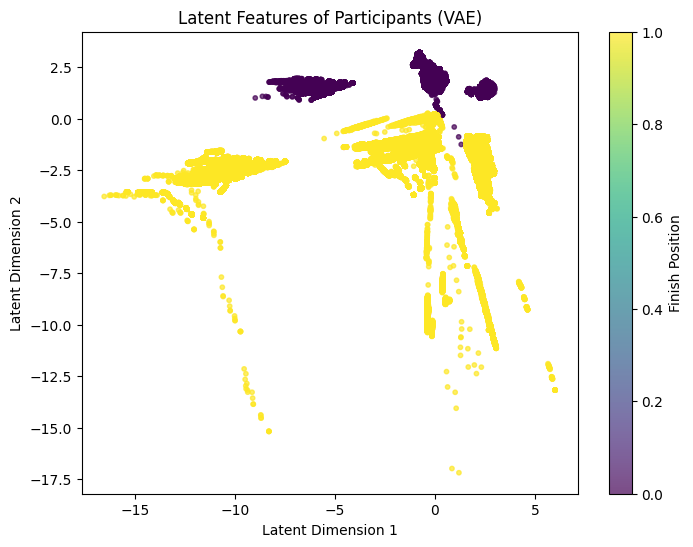

In [30]:
# Scatter plot of latent features
plt.figure(figsize=(8, 6))
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=vae_features['finish'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Finish Position')
plt.title("Latent Features of Participants (VAE)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


### **Wasserstein GAN (WGAN)**

A **Wasserstein GAN (WGAN)** is a type of Generative Adversarial Network (GAN) that uses the **Wasserstein distance** as the measure of how close the synthetic data distribution is to the real data distribution. It improves the stability of GAN training and ensures better-quality synthetic data generation.


### **Mathematical Definition**
The WGAN objective is:
$$
\min_G \max_{D \in \mathcal{C}} \mathbb{E}_{x \sim p_{\text{data}}}[D(x)] - \mathbb{E}_{z \sim p_z}[D(G(z))]
$$
where:
- $G$ is the Generator, which generates synthetic data $G(z)$ from random noise $z \sim p_z$.
- $D$ is the Critic (not a discriminator), which scores how real or fake the data is.
- $p_{\text{data}}$ is the real data distribution.
- $\mathcal{C}$ ensures $D$ is a 1-Lipschitz function, enforced through a **gradient penalty**.


#### **Wasserstein Distance**
It measures the minimum "effort" required to transform one distribution into another. This is more robust and meaningful than the original GAN's divergence-based loss.

For WGAN, the Critic approximates the Wasserstein distance by:
$$
W(p_{\text{data}}, p_g) \approx \mathbb{E}_{x \sim p_{\text{data}}}[D(x)] - \mathbb{E}_{z \sim p_z}[D(G(z))]
$$


#### **Purpose in This Project**
The WGAN is applied in this project to:
1. **Generate Synthetic Participant Data**: Create realistic participant features (e.g., `time`, `dist`, `dpos`, `alt`) conditioned on race properties like `difficulty_cluster`.

2. **Augment the Dataset**: Synthetic data generated by the WGAN can be used to fill gaps or explore scenarios not present in the original dataset.

3. **Stabilize Training**: The WGAN framework avoids issues like mode collapse and unstable training commonly seen in standard GANs.


#### **Key Advantages of WGAN**
1. **Stable Training**:
   - The Wasserstein distance provides a smoother loss function, reducing issues like mode collapse.

2. **Meaningful Loss Metric**:
   - The Critic loss directly correlates with the quality of the Generator’s outputs.

3. **Improved Quality of Synthetic Data**:
   - The use of the Wasserstein distance ensures synthetic data closely matches the real data distribution.

### **Why Not Use a Standard GAN?**
A standard GAN could suffer from unstable training and meaningless loss metrics due to the divergence measure used (e.g., JS Divergence). WGAN mitigates these issues with the Wasserstein distance and gradient penalty, making it better suited for high-dimensional data like this project.


In [20]:
# Normalize the features for participant data (e.g., `time`, `dist`, `dpos`, etc.)
participant_features = combined_data[['time', 'dist', 'dpos', 'alt']].values
race_features = combined_data[['difficulty_cluster']].values  # Categorical race features
scaler = MinMaxScaler()
participant_features_scaled = scaler.fit_transform(participant_features)

In [21]:
# Convert data to PyTorch tensors
participant_tensor = torch.tensor(participant_features_scaled, dtype=torch.float32)
race_tensor = torch.tensor(race_features, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(participant_tensor, race_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [22]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()  # Outputs scaled to [-1, 1]
        )
    
    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=1)  # Concatenate noise and condition
        return self.model(x)

# Critic
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)  # Output a scalar score
        )
    
    def forward(self, x):
        return self.model(x)

In [26]:
# Hyperparameters
noise_dim = 10  # Dimensionality of noise input
condition_dim = race_tensor.shape[1]  # Dimensionality of race condition
output_dim = participant_tensor.shape[1]  # Output features for participants
lr = 1e-4
n_critic = 2  # Number of Critic updates per Generator update
epochs = 30
lambda_gp = 10  # Gradient penalty coefficient

In [27]:
# Initialize models, optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim, condition_dim, output_dim).to(device)
critic = Critic(output_dim + condition_dim).to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_c = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))
scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training

In [28]:
# Gradient Penalty for WGAN-GP
def gradient_penalty(critic, real_data, fake_data, condition):
    alpha = torch.rand(real_data.size(0), 1).to(device)
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated = torch.cat([interpolated, condition], dim=1).requires_grad_(True)
    scores = critic(interpolated)
    gradients = torch.autograd.grad(
        outputs=scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

In [29]:
generator.train()
critic.train()
for epoch in range(epochs):
    for i, (real_participants, conditions) in enumerate(dataloader):
        real_participants, conditions = real_participants.to(device), conditions.to(device)
        batch_size = real_participants.size(0)

        # Train Critic
        for _ in range(n_critic):  # Reduced to 2 critic updates
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_participants = generator(noise, conditions)
            real_data = torch.cat([real_participants, conditions], dim=1)
            fake_data = torch.cat([fake_participants.detach(), conditions], dim=1)

            real_scores = critic(real_data)
            fake_scores = critic(fake_data)
            gp = gradient_penalty(critic, real_participants, fake_participants, conditions)
            loss_critic = -(torch.mean(real_scores) - torch.mean(fake_scores)) + lambda_gp * gp

            optimizer_c.zero_grad()
            scaler.scale(loss_critic).backward()
            scaler.step(optimizer_c)
            scaler.update()

        # Train Generator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_participants = generator(noise, conditions)
        fake_data = torch.cat([fake_participants, conditions], dim=1)
        loss_generator = -torch.mean(critic(fake_data))

        optimizer_g.zero_grad()
        scaler.scale(loss_generator).backward()
        scaler.step(optimizer_g)
        scaler.update()

    print(f"Epoch [{epoch+1}/{epochs}], Loss Critic: {loss_critic.item():.6f}, Loss Generator: {loss_generator.item():.6f}")

c:\Users\aleca\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/30], Loss Critic: 0.003207, Loss Generator: -1.688831
Epoch [2/30], Loss Critic: -0.006910, Loss Generator: -1.586032
Epoch [3/30], Loss Critic: -0.001941, Loss Generator: -1.640797
Epoch [4/30], Loss Critic: -0.002290, Loss Generator: -1.734899
Epoch [5/30], Loss Critic: 0.000043, Loss Generator: -1.789148
Epoch [6/30], Loss Critic: -0.001049, Loss Generator: -1.950320
Epoch [7/30], Loss Critic: -0.000434, Loss Generator: -2.032636
Epoch [8/30], Loss Critic: 0.002823, Loss Generator: -2.414086
Epoch [9/30], Loss Critic: 0.000406, Loss Generator: -2.709533
Epoch [10/30], Loss Critic: 0.003772, Loss Generator: -3.389560
Epoch [11/30], Loss Critic: -0.000699, Loss Generator: -4.307523
Epoch [12/30], Loss Critic: -0.006701, Loss Generator: -5.960593
Epoch [13/30], Loss Critic: 0.002725, Loss Generator: -8.212989
Epoch [14/30], Loss Critic: 0.004087, Loss Generator: -10.082425
Epoch [15/30], Loss Critic: 0.012479, Loss Generator: -12.097186
Epoch [16/30], Loss Critic: -0.000146, L

#### Save model

In [30]:
# Save the Generator model
torch.save(generator.state_dict(), 'generator_wgan.pth')

# Save the Critic model
torch.save(critic.state_dict(), 'critic_wgan.pth')

print("Models saved successfully!")

Models saved successfully!


#### Load model

In [ ]:
# Reinitialize the models
generator = Generator(noise_dim, condition_dim, output_dim).to(device)
critic = Critic(output_dim + condition_dim).to(device)

# Load the saved weights
generator.load_state_dict(torch.load('generator_wgan.pth'))
critic.load_state_dict(torch.load('critic_wgan.pth'))

print("Models loaded successfully!")

#### **Sintetic data generation**

The table below shows the first five synthetic data samples generated by the WGAN model. Each sample represents participant features (e.g., `time`, `dist`, `dpos`, and `alt`) conditioned on race difficulty clusters.

In [ ]:
# Generate synthetic data
generator.eval()  # Set Generator to evaluation mode
num_samples = 100  # Number of synthetic samples to generate

# Generate random noise and conditions
noise = torch.randn(num_samples, noise_dim).to(device)
random_conditions = torch.randint(0, int(race_tensor.max().item()) + 1, (num_samples, condition_dim)).to(device)

# Generate synthetic participant features
synthetic_data = generator(noise, random_conditions).detach().cpu().numpy()

data_scaler = MinMaxScaler()  # Create a new MinMaxScaler

# Refit the data_scaler to the original participant data if necessary
data_scaler.fit(participant_features) 

# Apply inverse transformation to scale synthetic data back to the original range
synthetic_data_rescaled = data_scaler.inverse_transform(synthetic_data)

# Display the first few samples of synthetic data
print("Synthetic Data (First 5 Samples):")
print(synthetic_data_rescaled[:5])


Synthetic Data (First 5 Samples):
[[8.02987099e+00 9.12540588e+01 3.13791748e+03 5.27296204e+02]
 [4.50516701e+01 1.58895554e+02 9.39690625e+03 1.36243494e+03]
 [9.26592350e+00 1.07589935e+02 4.22592920e+03 7.62253479e+02]
 [1.29019194e+01 9.05776443e+01 4.34283008e+03 1.44721143e+03]
 [1.60763760e+01 7.72673187e+01 6.23997070e+02 4.57299576e+01]]


#### **Sintetic data vs real data**

The first visualization compares the distributions of real and synthetic participant data for four features: `time`, `dist`, `dpos`, and `alt`. 

**Key Observations**:
  - The synthetic distributions (orange) align closely with the real data distributions (blue), especially for `dist`.
  - Slight deviations exist for features like `dpos` and `alt`, which may indicate areas where the WGAN model could improve.

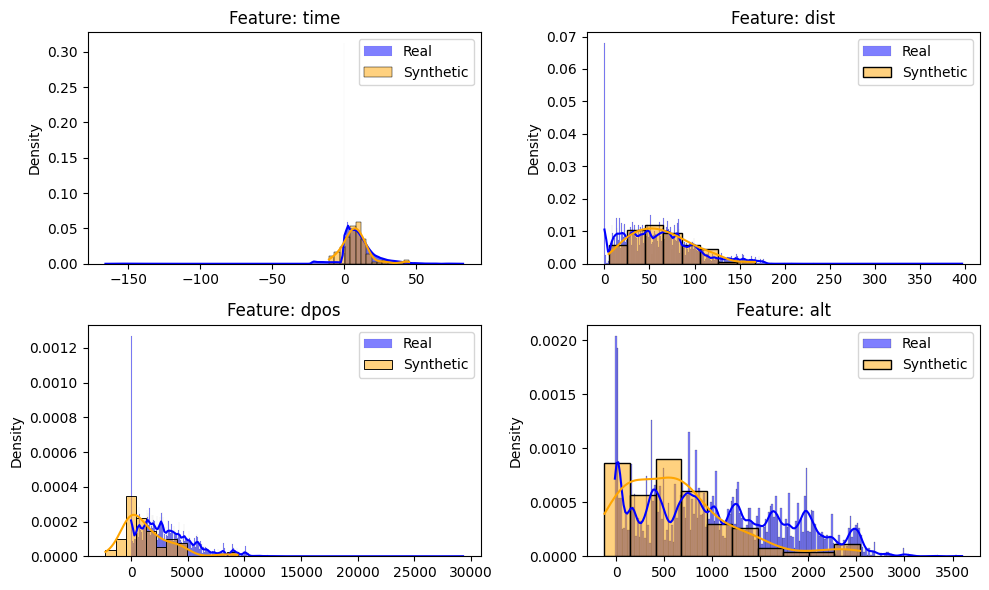

In [42]:
# Ensure the correct scaler is used for inverse transformation
real_data_rescaled = data_scaler.inverse_transform(participant_features_scaled)

# Visualize distributions of real vs. synthetic participant features
plt.figure(figsize=(10, 6))
for i, feature in enumerate(['time', 'dist', 'dpos', 'alt']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(real_data_rescaled[:, i], color='blue', label='Real', kde=True, stat='density', alpha=0.5)
    sns.histplot(synthetic_data_rescaled[:, i], color='orange', label='Synthetic', kde=True, stat='density', alpha=0.5)
    plt.title(f"Feature: {feature}")
    plt.legend()
plt.tight_layout()
plt.show()


#### **Latent space**

It represents the latent space of synthetic data conditioned on difficulty clusters. Each point corresponds to a synthetic sample, colored by its associated difficulty cluster.

- **Key Observations**:
  - The latent space shows distinct groupings for difficulty clusters.
  - This indicates that the WGAN successfully captured the relationship between race conditions and participant features.


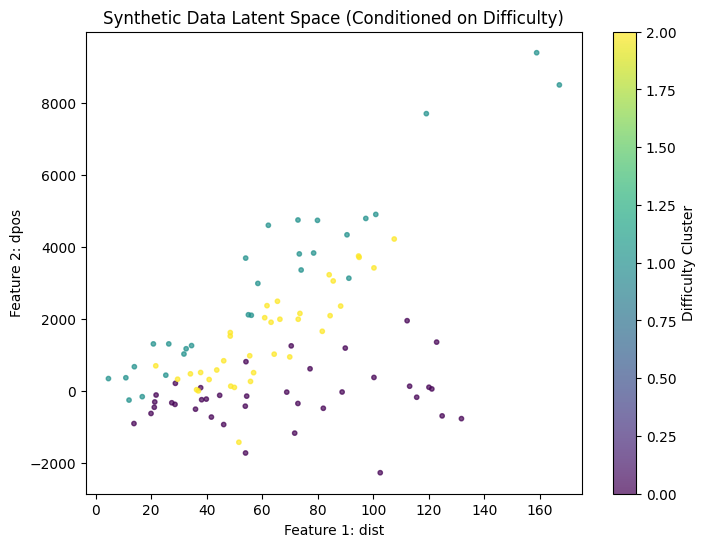

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(synthetic_data_rescaled[:, 1], synthetic_data_rescaled[:, 2], c=random_conditions[:, 0].cpu(), cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Difficulty Cluster')
plt.title("Synthetic Data Latent Space (Conditioned on Difficulty)")
plt.xlabel("Feature 1: dist")
plt.ylabel("Feature 2: dpos")
plt.show()


#### **Metric evaluation**

Quality of synthetic data against the real dataset using metrics (e.g., Wasserstein distance). 

**Key Observations**:
  - Metrics indicate the synthetic data's quality and the WGAN's performance in approximating the distribution of the real data.
  - Specific insights would depend on the numerical values derived from these evaluations.

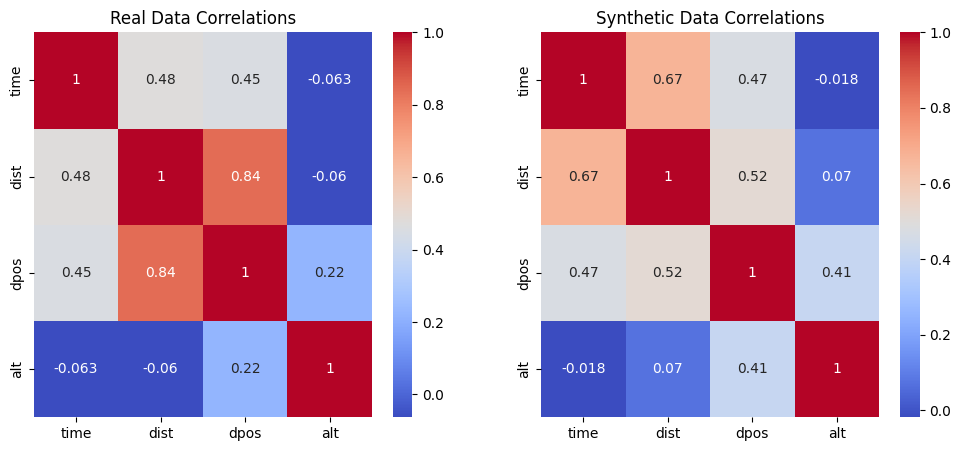

In [44]:
# Compute correlations for real and synthetic data
real_corr = pd.DataFrame(real_data_rescaled, columns=['time', 'dist', 'dpos', 'alt']).corr()
synthetic_corr = pd.DataFrame(synthetic_data_rescaled, columns=['time', 'dist', 'dpos', 'alt']).corr()

# Visualize correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(real_corr, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title("Real Data Correlations")
sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title("Synthetic Data Correlations")
plt.show()


#### **Gibss Sampling for Syntetic Data**

In [45]:
def gibbs_sampling_synthetic(data, num_iterations=1000):
    samples = []

    # Initialize variables randomly
    current_state = {
        'difficulty_cluster': random.choice(data['difficulty_cluster'].unique()),
        'prop_dropped': random.choice(data['prop_dropped'].unique()),
        'time': random.choice(data['time'].unique())
    }

    for _ in range(num_iterations):
        # Sample difficulty_cluster given prop_dropped and time
        sampled_cluster = inference.query(
            variables=['difficulty_cluster'],
            evidence={'prop_dropped': current_state['prop_dropped'], 'time': current_state['time']}
        )
        current_state['difficulty_cluster'] = random.choices(
            population=sampled_cluster.state_names['difficulty_cluster'],
            weights=sampled_cluster.values
        )[0]

        # Sample prop_dropped given difficulty_cluster and time
        sampled_prop_dropped = inference.query(
            variables=['prop_dropped'],
            evidence={'difficulty_cluster': current_state['difficulty_cluster'], 'time': current_state['time']}
        )
        current_state['prop_dropped'] = random.choices(
            population=sampled_prop_dropped.state_names['prop_dropped'],
            weights=sampled_prop_dropped.values
        )[0]

        # Sample time given difficulty_cluster and prop_dropped
        sampled_time = inference.query(
            variables=['time'],
            evidence={'difficulty_cluster': current_state['difficulty_cluster'], 'prop_dropped': current_state['prop_dropped']}
        )
        current_state['time'] = random.choices(
            population=sampled_time.state_names['time'],
            weights=sampled_time.values
        )[0]

        # Save the current state
        samples.append(current_state.copy())

    return samples


# Ensure the synthetic data is properly formatted for the Bayesian network
synthetic_bayesian_data = pd.DataFrame(synthetic_data_rescaled, columns=['time', 'dist', 'dpos', 'alt'])
synthetic_bayesian_data['difficulty_cluster'] = random.choices(['Cluster0', 'Cluster1', 'Cluster2'], k=len(synthetic_bayesian_data))
synthetic_bayesian_data['prop_dropped'] = random.choices(['Low', 'Medium', 'High'], k=len(synthetic_bayesian_data))
synthetic_bayesian_data['time'] = pd.qcut(synthetic_bayesian_data['time'], q=3, labels=['Short', 'Medium', 'Long'])

# Define a new inference object for the synthetic Bayesian network
synthetic_model = BayesianNetwork([
    ('difficulty_cluster', 'prop_dropped'),
    ('difficulty_cluster', 'time'),
    ('prop_dropped', 'time')
])
synthetic_model.fit(synthetic_bayesian_data, estimator=MaximumLikelihoodEstimator)
synthetic_inference = VariableElimination(synthetic_model)

# Run Gibbs Sampling on synthetic data
gibbs_samples_synthetic = gibbs_sampling_synthetic(synthetic_bayesian_data, num_iterations=1000)

# Analyze Results
print(f"First 10 Gibbs samples (Synthetic Data):\n{gibbs_samples_synthetic[:10]}")


First 10 Gibbs samples (Synthetic Data):
[{'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Low', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'Medium', 'time': 'Medium'}, {'difficulty_cluster': 'Cluster1', 'prop_dropped': 'High', 'time': 'Short'}, {'difficulty_cluster': 'Cluster0', 'prop_dropped': 'Medium', 'time': 'Medium'}]


#### **Conditional Probability for Syntetic Data**

In [46]:
def conditional_probability_synthetic(data, target_variable, evidence):
    """
    Calculate conditional probabilities for the synthetic data.

    Args:
        data (pd.DataFrame): Synthetic data.
        target_variable (str): The target variable for which to compute probabilities.
        evidence (dict): Evidence provided for conditional probabilities.

    Returns:
        pgmpy.inference.EliminationOrder: Query result with conditional probabilities.
    """
    # Perform the query
    query_result = synthetic_inference.query(
        variables=[target_variable],
        evidence=evidence
    )
    return query_result


# Example: Calculate the probability distribution of 'time' given a specific difficulty cluster
evidence = {'difficulty_cluster': 'Cluster1'}
conditional_prob_time = conditional_probability_synthetic(synthetic_bayesian_data, 'time', evidence)

print(f"Conditional probabilities for 'time' given difficulty_cluster = Cluster1 (Synthetic Data):")
print(conditional_prob_time)

# Example: Calculate the probability distribution of 'prop_dropped' given a specific difficulty cluster
evidence = {'difficulty_cluster': 'Cluster2'}
conditional_prob_dropped = conditional_probability_synthetic(synthetic_bayesian_data, 'prop_dropped', evidence)

print(f"Conditional probabilities for 'prop_dropped' given difficulty_cluster = Cluster2 (Synthetic Data):")
print(conditional_prob_dropped)

# Example: Visualize conditional probabilities for 'time' with different difficulty clusters
difficulty_clusters = synthetic_bayesian_data['difficulty_cluster'].unique()

for cluster in difficulty_clusters:
    evidence = {'difficulty_cluster': cluster}
    result = conditional_probability_synthetic(synthetic_bayesian_data, 'time', evidence)
    print(f"Difficulty Cluster: {cluster}")
    print(result)
    print("-" * 50)


Conditional probabilities for 'time' given difficulty_cluster = Cluster1 (Synthetic Data):
+--------------+-------------+
| time         |   phi(time) |
+==============+=============+
| time(Long)   |      0.3571 |
+--------------+-------------+
| time(Medium) |      0.3214 |
+--------------+-------------+
| time(Short)  |      0.3214 |
+--------------+-------------+
Conditional probabilities for 'prop_dropped' given difficulty_cluster = Cluster2 (Synthetic Data):
+----------------------+---------------------+
| prop_dropped         |   phi(prop_dropped) |
+======================+=====================+
| prop_dropped(High)   |              0.2667 |
+----------------------+---------------------+
| prop_dropped(Low)    |              0.4333 |
+----------------------+---------------------+
| prop_dropped(Medium) |              0.3000 |
+----------------------+---------------------+
Difficulty Cluster: Cluster1
+--------------+-------------+
| time         |   phi(time) |
+==============+=